# Задание 1
Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети

In [276]:
# Загружаем необходимые модули
from PIL import ImageDraw, Image, ImageFont
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import History 
from IPython.display import clear_output
import time 
from matplotlib import pyplot as plt

# Настраиваем создание собственного дата сета с изображением цифр
def get_image(number, option = {'text_location': (0, 0), 'rotate': 0}):
    img = Image.new('RGB', (28, 28), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", img.size[0])
    draw.text(option['text_location'], str(number), fill = 'black', font=font)
    img = img.rotate(option['rotate'])
    return img

# Нормализуем данные
def data_prepare(data):
    x_train = np.array([np.asarray(value[1].convert('L'))/255 for value in data])
    y_train = OneHotEncoder().fit_transform(np.array([value[0] for value in data]).reshape((-1, 1))).toarray()

    random.shuffle(data)
    x_test = np.array([np.asarray(value[1].convert('L'))/255 for value in data])
    y_test = OneHotEncoder().fit_transform(np.array([value[0] for value in data]).reshape((-1, 1))).toarray()
    return x_train, y_train, x_test, y_test

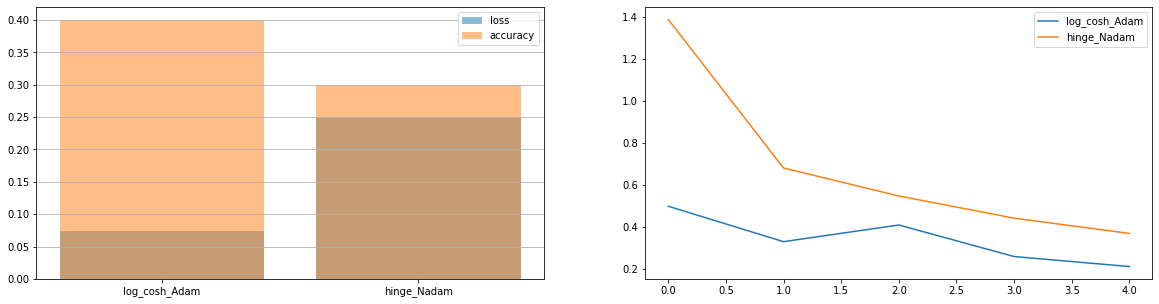

In [274]:
# Проверим для начала какие loss и accuracy показывают лучшие показатели
Probabilistic_losses = ['BinaryCrossentropy', 'CategoricalCrossentropy', 'Poisson', 'binary_crossentropy', 'categorical_crossentropy', 'poisson', 'KLDivergence', 'kl_divergence']
Regression_losses = ['MeanSquaredError', 'MeanAbsoluteError', 'MeanAbsolutePercentageError', 'MeanSquaredLogarithmicError', 'CosineSimilarity', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'Huber', 'huber', 'LogCosh', 'log_cosh']
Hinge_losses = ['Hinge', 'SquaredHinge', 'CategoricalHinge', 'hinge', 'squared_hinge', 'categorical_hinge']
keras_loss = Probabilistic_losses+Regression_losses+Hinge_losses
keras_acc = ['Adadelta', 'Adagrad','Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD']

# Формируем список из изображений и цифр изображенных на них
data = [(i, get_image(i)) for i in range(10)]
# Нормализуем данные
x_train, y_train, x_test, y_test = data_prepare(data)
# Проверяем все варианты
result = {}
for i, loss in enumerate(keras_loss):
    for j, acc in enumerate(keras_acc):
        
        # Создание модели
        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10)
        ])
        clear_output(wait=True)
        print(f'{i}_{j}/{len(keras_loss)}_{len(keras_acc)}')
        try:
            # Компиляция модели
            model.compile(optimizer=acc,
                          loss=loss,
                          metrics=['accuracy'])
            # Обучение модели
            hist = model.fit(x_train, y_train, epochs=5, verbose=0, callbacks=[History()])
            # Оценка модели на тестовых данных
            check=model.evaluate(x_test, y_test, verbose=0)
            result[f'{loss}_{acc}']=(check, hist)
        except Exception as e:
            result[f'{loss}_{acc}'] = e

# Оставляем только лучшие результаты
clear_output(wait=True)           
x = []
y_1 = []
y_2 = []
y_3 = []
for k, value in result.items():
    name = k
    loss = value[0][0]
    accuracy = value[0][1]
    if accuracy>0.25 and 0.0<loss< 0.25:
        x.append(name)
        y_1.append(loss)
        y_2.append(accuracy) 
        y_3.append(value[1].history['loss'])

# Выводим что получилось
figure, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].bar(x, y_1, label = 'loss', alpha=0.5)
axis[0].bar(x, y_2, label = 'accuracy', alpha=0.5)
axis[0].grid(b=True, axis='y')
axis[0].legend();

for i, name in enumerate(x): 
    axis[1].plot(np.arange(0, len(y_3[i])), y_3[i], label = name)
    axis[1].legend();


Первые результаты показли что лучший вариант получается при использовании loss = log_cosh и accurasy = Adam. Попробуем добавить еще слоев.

Лучшие результаты:
loss:		0.002770776394754648
accuracy:	1.0
Точность предсказания составляет:	100.00 %


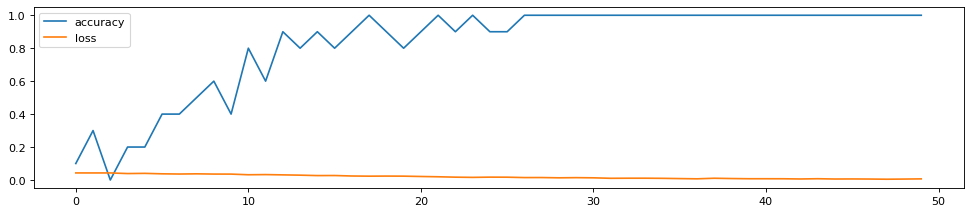

In [277]:
# Формируем список из изображений и цифр изображенных на них
data = [(i, get_image(i)) for i in range(10)]

# Нормализуем данные
x_train, y_train, x_test, y_test = data_prepare(data)

# Проводим 10 тестов новой модели
best_loss = 100
best_acc = 0
best_hist = None
best_model = None
for i in range(10):
    print('test', i)
    clear_output(wait=True)
    # Создание модели
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10)
    ])

    # Компиляция модели
    model.compile(optimizer='Adam',
                  loss='log_cosh',
                  metrics=['accuracy'])
    # Обучение модели
    hist = model.fit(x_train, y_train, epochs=50, verbose=0, callbacks=[History()])
    # Оценка модели на тестовых данных
    check=model.evaluate(x_test, y_test, verbose=0)
    loss = check[0]
    acc = check[1]
    if loss<best_loss and acc>best_acc:
        best_loss = loss
        best_acc = acc
        best_hist = hist
        best_model = model
        
# Выводим лучший результат
clear_output(wait=True)
print(f'Лучшие результаты:\nloss:\t\t{best_loss}\naccuracy:\t{best_acc}')
check = []
for i, v in enumerate(best_model.predict(x_test, verbose = 0)):
    if y_test[i].argmax()==v.argmax():
        check.append(1)
    else:
        check.append(0)
print(f'Точность предсказания составляет:\t{(sum(check)/len(check))*100:.2f} %')
plt.figure(figsize=(15, 3), dpi=80)
plt.plot(np.arange(len(best_hist.history['accuracy'])), best_hist.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(len(best_hist.history['loss'])), best_hist.history['loss'], label = 'loss')
plt.legend();

В целом результаты уже более чем удовлетворительные, но попробуем разнообразить изображения

Лучшие результаты:
loss:		0.0063692317344248295
accuracy:	0.9950000047683716
Точность предсказания составляет:	99.50 %


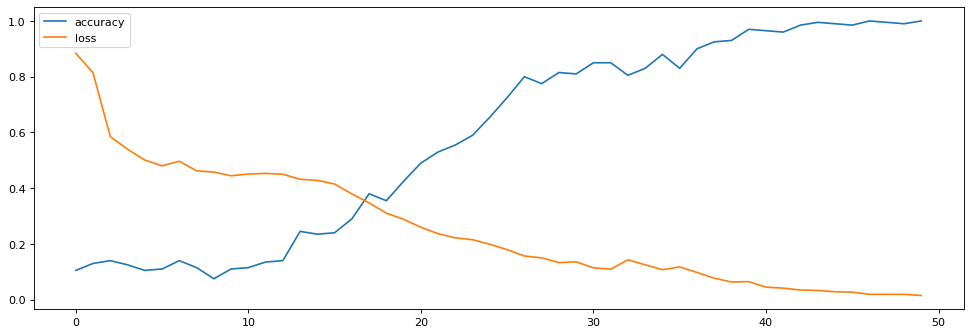

In [220]:
# Создаем новый датасет с различным положение цифры на изображении
data = []
for n in range(10):
    for l in [0, 5, 10, 15]:
        for r in [0, 15, 30, 60, 90]:
            data.append((n, get_image(n, option = {'text_location': (l, 0), 'rotate': r})))

# Нормализуем данные
x_train, y_train, x_test, y_test = data_prepare(data)

# Проводим 10 тестов модели на новых данных
best_loss = 100
best_acc = 0
best_hist = None
best_model = None
for i in range(10):
    print('test', i)
    clear_output(wait=True)
    # Создание модели
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10)
    ])

    # Компиляция модели
    model.compile(optimizer='Nadam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Обучение модели
    hist = model.fit(x_train, y_train, epochs=50, verbose=0, callbacks=[History()])
    # Оценка модели на тестовых данных
    check=model.evaluate(x_test, y_test, verbose=0)
    loss = check[0]
    acc = check[1]
    if loss<best_loss and acc>best_acc:
        best_loss = loss
        best_acc = acc
        best_hist = hist
        best_model = model

# Выводим лучший результат
clear_output(wait=True)
print(f'Лучшие результаты:\nloss:\t\t{best_loss}\naccuracy:\t{best_acc}')
check = []
for i, v in enumerate(best_model.predict(x_test, verbose = 0)):
    if y_test[i].argmax()==v.argmax():
        check.append(1)
    else:
        check.append(0)
print(f'Точность предсказания составляет:\t{(sum(check)/len(check))*100:.2f} %')
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(np.arange(len(best_hist.history['accuracy'])), best_hist.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(len(best_hist.history['loss'])), best_hist.history['loss'], label = 'loss')
plt.legend();

Таким образом: подбор оптимальный loss и accuracy, увеличение разнообразия обучающих изображений, добавление дополнительных слоев, увеличение колличества эпох позволило нам в значительной степени улучшить результаты.

# Задание 2 
Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

DeepDream - это алгоритм генерации изображений, созданный Google в 2015 году. Этот алгоритм основан на использовании сверточных нейронных сетей, которые обучены на задаче классификации изображений. DeepDream производит итеративную оптимизацию входного изображения, чтобы активировать определенные нейроны и слои сети, что приводит к созданию уникальных, абстрактных изображений.  
Выбранная архитектура DeepDream - это Inception-v3, которая была разработана Google для классификации изображений. Она отличается от других архитектур своей способностью распознавать объекты на изображении на нескольких масштабах и уровнях абстракции. Также Inception-v3 использует архитектуру блоков, которые позволяют увеличить эффективность обучения и использования ресурсов.  
Плюсами данной архитектуры являются возможность распознавания объектов на изображении на разных уровнях абстракции и увеличение эффективности обучения. Минусами могут быть сложности в настройке и обучении сети, а также необходимость использования большого количества ресурсов.  
Трудности, которые могут возникнуть при применении данной архитектуры на практике, включают в себя необходимость настройки параметров и выбора подходящих входных данных, а также необходимость использования мощных вычислительных ресурсов для обучения сети и генерации изображений. Кроме того, созданные изображения могут быть сложны для интерпретации и использования в практических задачах, таких как распознавание объектов на изображении.  